In [6]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
from pathlib import Path

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['figure.dpi'] = 120

%matplotlib tk

In [7]:
def compute_csi_cvi(rr, t_rr, wind, fs_out=4.0, use_cubic=False):
    """Time-resolved CSI/CVI following MATLAB compute_CSI_CVI.m.
    rr      : 1D array of RR intervals (seconds), non-interpolated
    t_rr    : timestamps for each RR (seconds), same length as rr
    wind    : window length in seconds (e.g., 15)
    fs_out  : output sampling frequency (Hz), default 4 Hz
    use_cubic: if True and SciPy available, use cubic interpolation
    returns: CSI_out, CVI_out, t_out
    """
    rr = np.asarray(rr, dtype=float)
    t_rr = np.asarray(t_rr, dtype=float)
    if rr.size < 3 or t_rr.size != rr.size:
        raise ValueError('RR/t_rr lengths invalid')

    # 1) Global SD1/SD2
    sd = np.diff(rr)
    SD01 = np.sqrt(0.5 * np.std(sd) ** 2)
    SD02 = np.sqrt(2 * (np.std(rr) ** 2) - (0.5 * np.std(sd) ** 2))

    # 2) Sliding-window SD1/SD2 (windows end at RR samples beyond first wind)
    t_start = t_rr[0]
    first_end = t_start + wind
    ixs = np.where(t_rr > first_end)[0]
    nt = max(len(ixs) - 1, 0)
    if nt == 0:
        raise ValueError('Not enough RR samples to form sliding windows')

    SD1 = np.zeros(nt)
    SD2 = np.zeros(nt)
    t_C = np.zeros(nt)

    for k in range(nt):
        i = ixs[k]
        t2 = t_rr[i]
        t1 = t2 - wind
        mask = (t_rr >= t1) & (t_rr <= t2)
        rr_win = rr[mask]
        sd_win = np.diff(rr_win)
        SD1[k] = np.sqrt(0.5 * np.std(sd_win) ** 2)
        SD2[k] = np.sqrt(2 * (np.std(rr_win) ** 2) - (0.5 * np.std(sd_win) ** 2))
        t_C[k] = t2  # end time of window

    # 3) Re-center to global baselines
    SD1 = SD1 - SD1.mean() + SD01
    SD2 = SD2 - SD2.mean() + SD02

    # 4) Map to CVI/CSI (scaled, matching MATLAB choice)
    CVI = SD1 * 10.0
    CSI = SD2 * 10.0

    # 5) Interpolate to uniform fs_out grid
    t_out = np.arange(t_C[0], t_C[-1] + 1/fs_out, 1/fs_out)
    if use_cubic:
        try:
            from scipy.interpolate import CubicSpline
            CVI_out = CubicSpline(t_C, CVI)(t_out)
            CSI_out = CubicSpline(t_C, CSI)(t_out)
        except Exception:
            CVI_out = np.interp(t_out, t_C, CVI)
            CSI_out = np.interp(t_out, t_C, CSI)
    else:
        CVI_out = np.interp(t_out, t_C, CVI)
        CSI_out = np.interp(t_out, t_C, CSI)

    return CSI_out, CVI_out, t_out, SD1, SD2, t_C

## Load ECG for sub-032 (rest_data_v2) and compute RR

In [8]:
sampling_rate = 1000
data_folder = Path('../digitspan/rest_data_v2')
subject_id = '050'
parquet_file = data_folder / f'sub-{subject_id}_task-rest_ecg_rest.parquet'

if not parquet_file.exists():
    raise FileNotFoundError(f'Missing file: {parquet_file}')

data = pd.read_parquet(parquet_file)
ecg_signal = data['ecg_nk']
clean = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)

print(f'Loaded {parquet_file.name}: shape={data.shape}, cols={list(data.columns)}')

# Process ECG to get R-peaks
signals, info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)
rpeaks = info['ECG_R_Peaks']
t_rr = rpeaks / sampling_rate  # seconds
rr = np.diff(t_rr)             # RR intervals in seconds
t_rr = t_rr[1:]                # align lengths (timestamps of RR samples)
print(f'R-peaks: {len(rpeaks)}; RR count: {len(rr)}')

Loaded sub-050_task-rest_ecg_rest.parquet: shape=(250281, 4), cols=['time', 'ecg_raw', 'ecg_mod', 'ecg_nk']
R-peaks: 316; RR count: 315
R-peaks: 316; RR count: 315


## Compute time-resolved CSI/CVI

In [9]:
wind = 15.0  # seconds (as in MATLAB)
CSI_out, CVI_out, t_out, SD1_win, SD2_win, t_C = compute_csi_cvi(rr, t_rr, wind, fs_out=4.0, use_cubic=False)

print(f'Outputs: CSI_out len={len(CSI_out)}, CVI_out len={len(CVI_out)}, t_out len={len(t_out)}')
print(f'SD1_win mean={SD1_win.mean():.4f}, SD2_win mean={SD2_win.mean():.4f}')

Outputs: CSI_out len=932, CVI_out len=932, t_out len=932
SD1_win mean=0.0449, SD2_win mean=0.0977


## Quick visualization

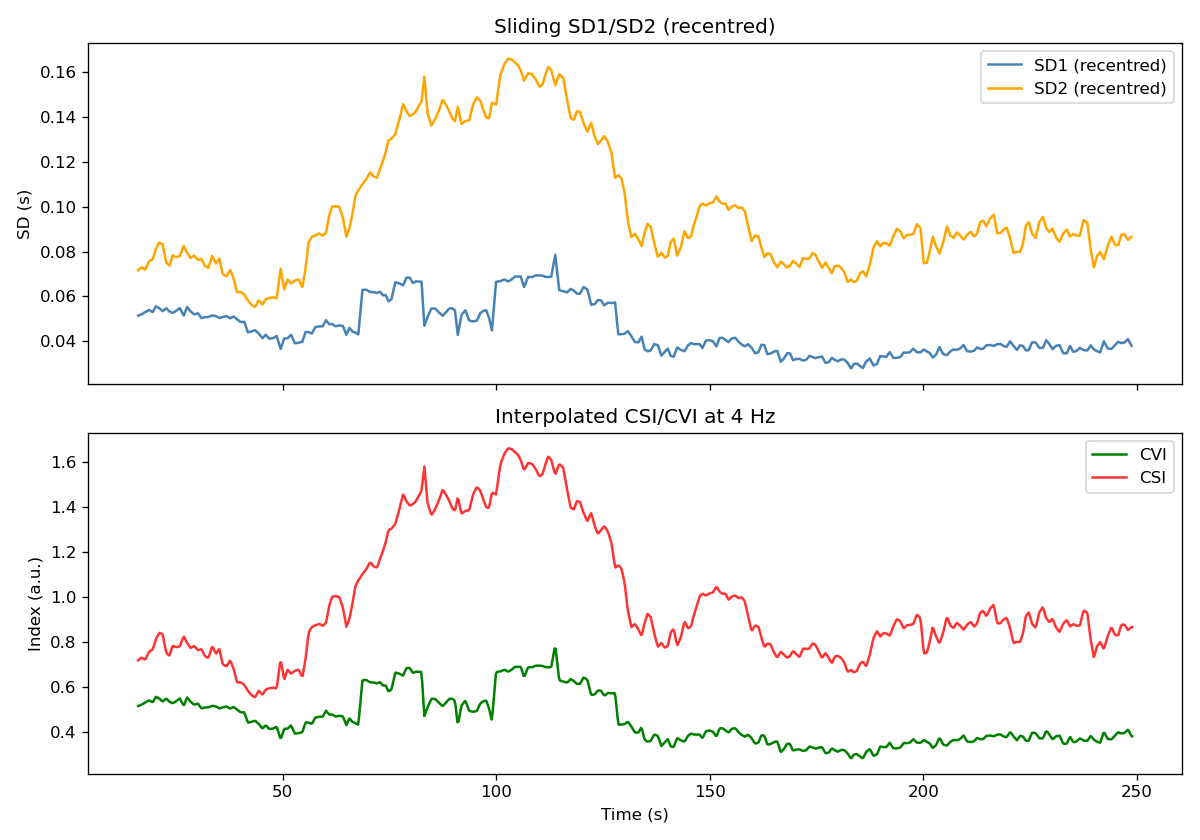

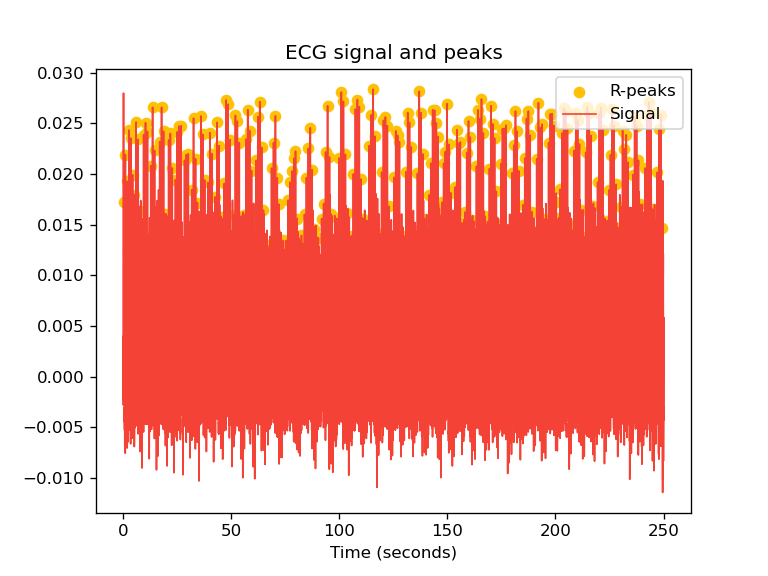

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
axes[0].plot(t_C, SD1_win, label='SD1 (recentred)', color='steelblue')
axes[0].plot(t_C, SD2_win, label='SD2 (recentred)', color='orange')
axes[0].set_ylabel('SD (s)')
axes[0].legend()
axes[0].set_title('Sliding SD1/SD2 (recentred)')

axes[1].plot(t_out, CVI_out, label='CVI', color='green')
axes[1].plot(t_out, CSI_out, label='CSI', color='red', alpha=0.8)
axes[1].set_ylabel('Index (a.u.)')
axes[1].legend()
axes[1].set_title('Interpolated CSI/CVI at 4 Hz')
axes[1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

# R-peak detection plot from cleaned signal
target = nk.ecg_peaks(clean, sampling_rate=sampling_rate, show=True)
